## Web scraping and Text analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [1]:
!pip install afinn

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53479 sha256=ab959f37ca825186db7f03fec01733565ebebcfc19e325107f1db5559d9b1587
  Stored in directory: c:\users\dell\appdata\local\packages\pythonsoftwarefoundation.python.3.12_qbz5n2kfra8p0\localcache\local\pip\cache\wheels\f9\72\27\74994e77200dae3d6aea2b546264500cee21f738c51241320b
Successfully built afinn



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [83]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import string
from afinn import Afinn
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import nltk
from nltk import FreqDist
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [84]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 1000

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 1000 total reviews
Scraping page 2
   ---> 2000 total reviews
Scraping page 3
   ---> 3000 total reviews
Scraping page 4
   ---> 3483 total reviews
Scraping page 5
   ---> 3483 total reviews
Scraping page 6
   ---> 3483 total reviews
Scraping page 7
   ---> 3483 total reviews
Scraping page 8
   ---> 3483 total reviews
Scraping page 9
   ---> 3483 total reviews
Scraping page 10
   ---> 3483 total reviews


In [85]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,"Not Verified | Flew premium, only worth the e..."
1,✅ Trip Verified | First our morning flight wa...
2,✅ Trip Verified | Although it was a bit uncom...
3,✅ Trip Verified | Boarding was decently organ...
4,✅ Trip Verified | Boarding on time and departu...


In [86]:
df["reviews"][3481]

'London City-New York JFK via Shannon on A318 but had really nice seats and professional crew. Meal served was very tasty and fresh. Overall a very good flight would use this airline again.'

In [87]:
len(df)

3483

In [88]:
df["reviews"][1]

"✅ Trip Verified |  First our morning flight was cancelled and moved to an afternoon flight, understanding sometimes these situations are unavoidable, however it lost us one day's experience in Cairo. We were quite upset when we got onto the plane and were squashed into regular seats, on both flights. As my husband had spasms, he had to stretch his legs across my lap, and not once did ANY of the attendants ask if we were okay as we were clearly struggling. As the service came to us for food, each choice we made we were told, they were all out and we had to settle for what they had left. I did the correct thing once home and sent in my complaints. They responded with a $100 pound voucher for our group."

In [89]:
ord(df["reviews"][1][0])

9989

In [90]:
chr(9989)

'✅'

In [91]:
def remove_additional_spaces(text):
  return re.sub(" +"," ",text)
  
l2 = " iam \n from        nizam college hyderabad, telangan indian"
remove_additional_spaces(l2)

' iam \n from nizam college hyderabad, telangan indian'

In [92]:
def preprocess(text):
  text = text.lower()
  s =chr(9989)
  if text.find(s) >= 0:
    text = text.replace(s,"")
  if text.find("|") >= 0: 
    text = text.replace("|","")
  if text.find("trip verified") >= 0:
    text = text.replace("trip verified","")
  if text.find("not verified") >= 0:
    text = text.replace("not verified","")

  text = remove_additional_spaces(text)

  return text
  

In [93]:
cleaned_text = []
for i in range(len(df)):
  k = preprocess(df["reviews"][i])
  cleaned_text.append(k)

In [94]:
df["cleaned_reviews"] = cleaned_text

In [95]:
df.head()

,reviews,cleaned_reviews
0,"Not Verified | Flew premium, only worth the e...","flew premium, only worth the extra money for ..."
1,✅ Trip Verified | First our morning flight wa...,first our morning flight was cancelled and mo...
2,✅ Trip Verified | Although it was a bit uncom...,although it was a bit uncomfortable flight in...
3,✅ Trip Verified | Boarding was decently organ...,boarding was decently organised. the a380 sti...
4,✅ Trip Verified | Boarding on time and departu...,boarding on time and departure on time for a ...


In [96]:


#remove punctuation
df['cleaned_reviews'] = df['cleaned_reviews'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

In [97]:
df.head()

,reviews,cleaned_reviews
0,"Not Verified | Flew premium, only worth the e...",flew premium only worth the extra money for t...
1,✅ Trip Verified | First our morning flight wa...,first our morning flight was cancelled and mo...
2,✅ Trip Verified | Although it was a bit uncom...,although it was a bit uncomfortable flight in...
3,✅ Trip Verified | Boarding was decently organ...,boarding was decently organised the a380 stil...
4,✅ Trip Verified | Boarding on time and departu...,boarding on time and departure on time for a ...


In [98]:
#instantiate afinn
afn = Afinn()
 
#creating list sentences
          
# compute scores (polarity) and labels
cleaned_reviews = df["cleaned_reviews"]
scores = [afn.score(df) for df in cleaned_reviews]
sentiment = ['positive' if score > 0
                          else 'negative' if score < 0
                              else 'neutral'
                                  for score in scores]
     
# dataframe creation
df = pd.DataFrame()
df['cleaned_reviews'] =  cleaned_reviews
df['scores'] = scores
df['sentiments'] = sentiment

In [99]:
df.head()

,cleaned_reviews,scores,sentiments
0,flew premium only worth the extra money for t...,0.0,neutral
1,first our morning flight was cancelled and mo...,-9.0,negative
2,although it was a bit uncomfortable flight in...,4.0,positive
3,boarding was decently organised the a380 stil...,4.0,positive
4,boarding on time and departure on time for a ...,2.0,positive


In [100]:
df["sentiments"].value_counts()

positive    1964
negative    1366
neutral      153
Name: sentiments, dtype: int64

In [101]:
def count_values_in_column(data,feature): 
  total=data.loc[:,feature].value_counts(dropna=False) 
  percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2) 
  return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [102]:
#Count_values for sentiment
count_values_in_column(df,"sentiments")

,Total,Percentage
positive,1964,56.39
negative,1366,39.22
neutral,153,4.39


In [103]:
df1 = count_values_in_column(df,"sentiments")

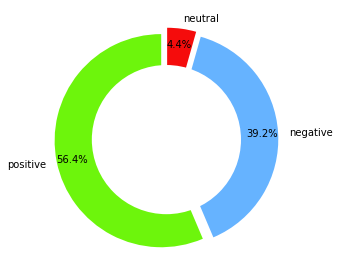

In [121]:
# Pie chart
labels = ['positive', 'negative', 'neutral']
sizes = df1['Percentage']
#colors
colors = ['#6df50c','#66b3ff','#f50c0c']


#explsion
explode = (0.05,0.05,0.05)
 
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle 
plt.tight_layout()
plt.show()

In [105]:
text = " ".join(df["cleaned_reviews"].tolist())
text = text.split()
filtered_words = [word for word in text if word not in stopwords.words('english')]

In [106]:
fdist_text = FreqDist(filtered_words)

In [107]:
fdist_text


FreqDist({'flight': 6132, 'ba': 4223, 'service': 2644, 'seat': 2280, 'food': 2273, 'london': 2096, 'crew': 2064, 'british': 2032, 'airways': 2016, 'good': 2006, ...})

In [108]:
words = list(fdist_text.keys())
count = list(fdist_text.values())



In [109]:
d = {"words" : words,"freq" : count}
word_df = pd.DataFrame(d)

In [110]:
word_df.head()

,words,freq
0,flew,618
1,premium,639
2,worth,204
3,extra,442
4,money,362


In [111]:
word_df.sort_values("freq",ascending = False,inplace = True)

In [112]:
values = word_df["words"].tolist()[:10]
count = word_df["freq"].tolist()[:10]

<ipython-input-113-83557abd9702>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(values,rotation = 90, fontsize = 10)


<BarContainer object of 10 artists>

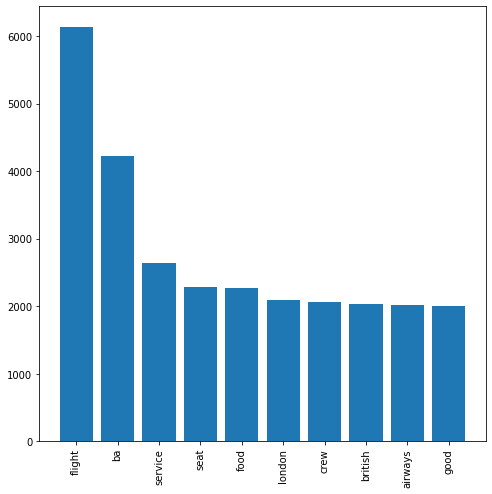

In [113]:
fig, ax = plt.subplots(figsize=(8,8))  
ax= plt.subplot()
ax.xaxis.set_ticklabels(values,rotation = 90, fontsize = 10)
plt.bar(values,count)

In [115]:
text = " ".join(text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="black", width=800, height=400).generate(text)

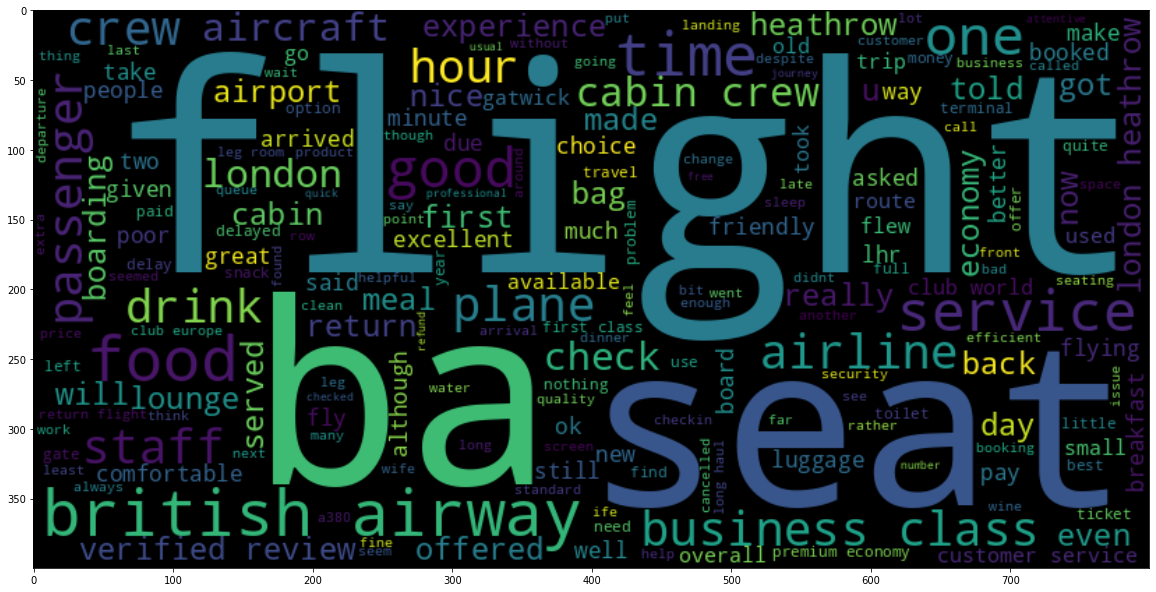

In [116]:
plt.figure(figsize=(20,30))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [117]:
positive_text = []
negative_text = []
neutral_text = []
for i in range(len(df)):
  if df["sentiments"][i] == "positive":
    positive_text.append(df["cleaned_reviews"][i])

  elif df["sentiments"][i] == "negative":
    negative_text.append(df["cleaned_reviews"][i])
  else:
    neutral_text.append(df["cleaned_reviews"][i])


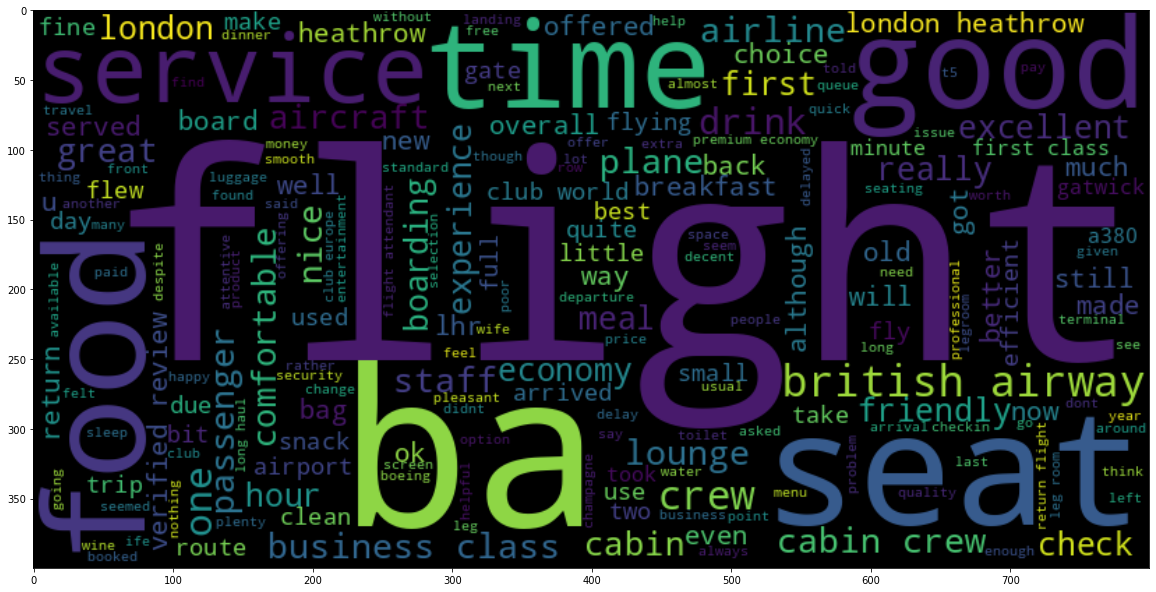

In [118]:
text = " ".join(positive_text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="black", width=800, height=400).generate(text)
plt.figure( figsize=(20,30))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

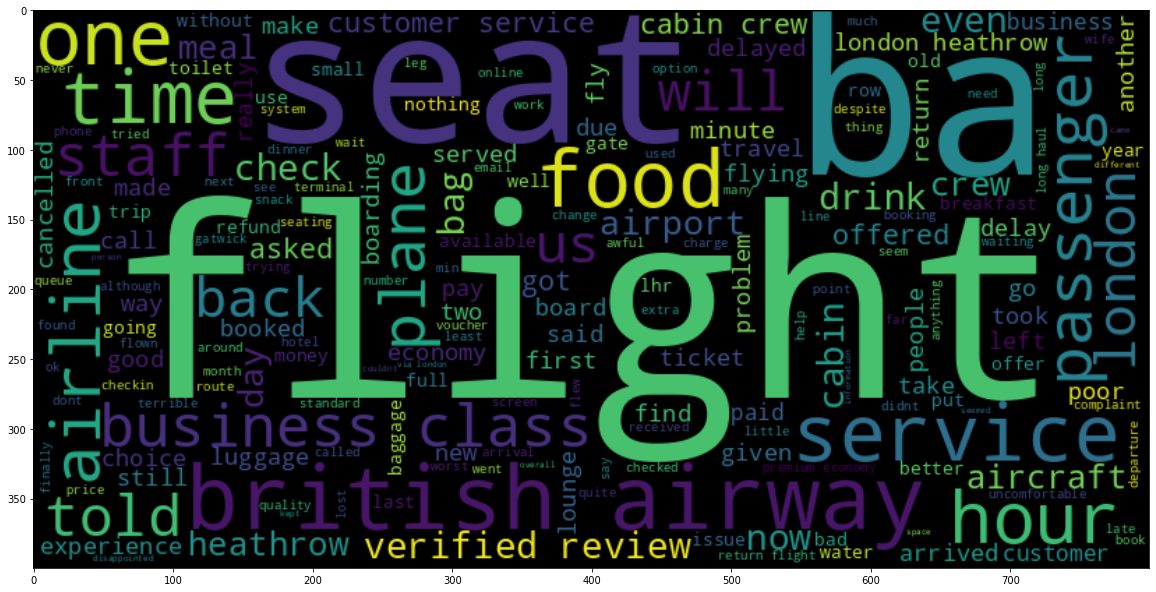

In [119]:
text = " ".join(negative_text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="black", width=800, height=400).generate(text)
plt.figure( figsize=(20,30))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

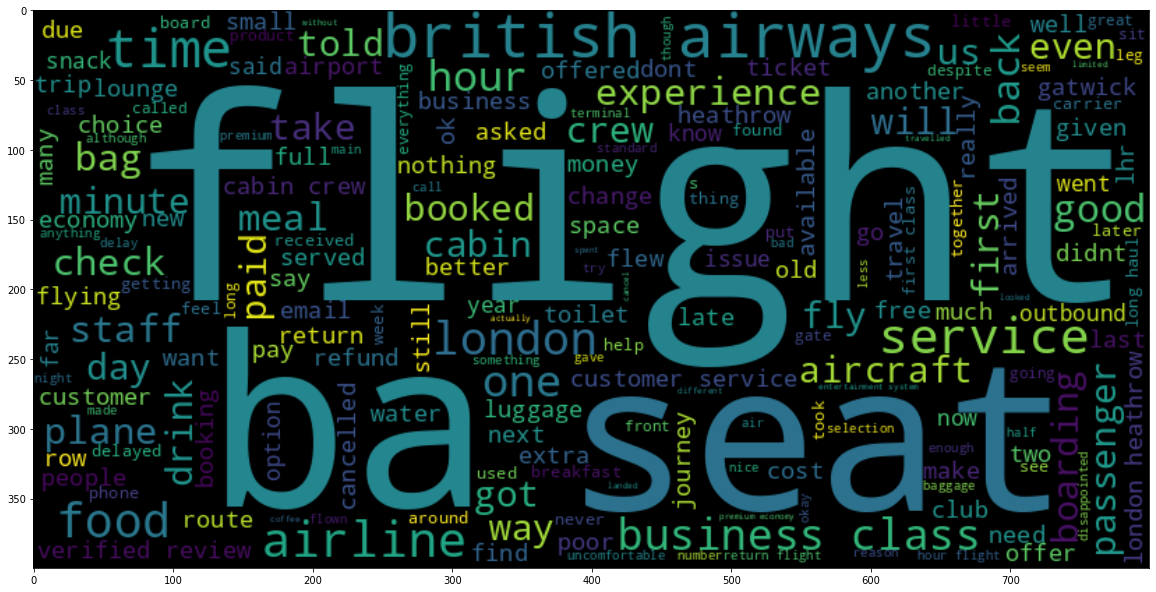

In [120]:
text = " ".join(neutral_text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="black", width=800, height=400).generate(text)
plt.figure( figsize=(20,30))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()